In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.1


In [3]:
import pandas as pd

df_train = pd.read_parquet("hf://datasets/Helsinki-NLP/opus-100/en-id/train-00000-of-00001.parquet")

df_train.head()

C:\Users\nazuh\.conda\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,translation
0,"{'en': 'Hmm. _', 'id': 'Hmm.'}"
1,"{'en': 'Back the fuck up!', 'id': 'Mundurlah, ..."
2,"{'en': 'Rebecca have a good think about it.', ..."
3,"{'en': 'You're wrong.', 'id': 'Kau salah.'}"
4,"{'en': 'Brook, what do you have to say for you..."


In [4]:
num_of_data = 100000

df_train_reduced = df_train.head(num_of_data)
df_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   translation  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB


In [5]:
# Extract English and Indonesian train texts
english_train = df_train_reduced['translation'].apply(lambda x: x['en']).tolist()
indonesian_train = df_train_reduced['translation'].apply(lambda x: x['id']).tolist()

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenization
english_tokenizer = Tokenizer()
indonesian_tokenizer = Tokenizer()

english_tokenizer.fit_on_texts(english_train)
indonesian_tokenizer.fit_on_texts(indonesian_train)

# Convert texts to sequences
english_sequences = english_tokenizer.texts_to_sequences(english_train)
indonesian_sequences = indonesian_tokenizer.texts_to_sequences(indonesian_train)

english_vocab_size = len(english_tokenizer.word_index) + 1
indonesian_vocab_size = len(indonesian_tokenizer.word_index) + 1

print(english_vocab_size)
print(indonesian_vocab_size)

31245
35276


In [7]:
df_validation = pd.read_parquet("hf://datasets/Helsinki-NLP/opus-100/en-id/validation-00000-of-00001.parquet")

df_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   translation  2000 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB


In [8]:
num_of_data = 2000

df_validation_reduced = df_validation.head(num_of_data)

english_validation = df_validation_reduced['translation'].apply(lambda x: x['en']).tolist()
indonesian_validation = df_validation_reduced['translation'].apply(lambda x: x['id']).tolist()

# Prepare validation data in the same way
validation_english_sequences = english_tokenizer.texts_to_sequences(english_validation)
validation_indonesian_sequences = indonesian_tokenizer.texts_to_sequences(indonesian_validation)

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define a consistent maximum sequence length based on the longest sequence in both datasets
max_sequence_length = 60

# Pad the English and Indonesian sequences for training to the same fixed maximum length
english_sequences = pad_sequences(english_sequences, maxlen=max_sequence_length, padding='post')
indonesian_sequences = pad_sequences(indonesian_sequences, maxlen=max_sequence_length, padding='post')

# Pad the validation sequences to the same maximum sequence length
validation_english_sequences = pad_sequences(validation_english_sequences, maxlen=max_sequence_length, padding='post')
validation_indonesian_sequences = pad_sequences(validation_indonesian_sequences, maxlen=max_sequence_length, padding='post')

# Check the shapes to confirm alignment
print("Shape of input_sequences:", english_sequences.shape)
print("Shape of target_sequences:", indonesian_sequences.shape)
print("Shape of validation_english_sequences:", validation_english_sequences.shape)
print("Shape of validation_target_sequences:", validation_indonesian_sequences.shape)
print(max_sequence_length)

Shape of input_sequences: (100000, 60)
Shape of target_sequences: (100000, 60)
Shape of validation_english_sequences: (2000, 60)
Shape of validation_target_sequences: (2000, 60)
60


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Define the Model
embedding_dim = 64

model = Sequential([
    Embedding(input_dim=english_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(128, return_sequences=True),
    Dense(indonesian_vocab_size, activation='softmax')
])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger

# Define the path for saving the model and logs
path = "C:/Kuliah/7Sem/NLP/RNN/models-100k-2k/"

checkpoint = ModelCheckpoint(path + 'modelrnn-2_layer-{epoch:02d}.keras', verbose=1, save_best_only=False)
csv_logger = CSVLogger(path + "log-hasil.csv", append=True, separator=';')

In [14]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train the Model
epochs = 10
batch_size = 32

history = model.fit(
    english_sequences, indonesian_sequences,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_english_sequences, validation_indonesian_sequences),
    callbacks=[checkpoint, csv_logger]
)

Epoch 1/10
3125/3125 [==============================] - ETA: 0s - loss: 0.8315 - accuracy: 0.9086
Epoch 1: saving model to C:/Kuliah/7Sem/NLP/RNN/models-100k-2k\modelrnn-2_layer-01.keras
3125/3125 [==============================] - 633s 201ms/step - loss: 0.8315 - accuracy: 0.9086 - val_loss: 0.7630 - val_accuracy: 0.9040
Epoch 2/10
3125/3125 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.9154
Epoch 2: saving model to C:/Kuliah/7Sem/NLP/RNN/models-100k-2k\modelrnn-2_layer-02.keras
3125/3125 [==============================] - 632s 202ms/step - loss: 0.6735 - accuracy: 0.9154 - val_loss: 0.7328 - val_accuracy: 0.9069
Epoch 3/10
3125/3125 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.9176
Epoch 3: saving model to C:/Kuliah/7Sem/NLP/RNN/models-100k-2k\modelrnn-2_layer-03.keras
3125/3125 [==============================] - 633s 203ms/step - loss: 0.6310 - accuracy: 0.9176 - val_loss: 0.7217 - val_accuracy: 0.9081
Epoch 4/10
3125/3125 [======

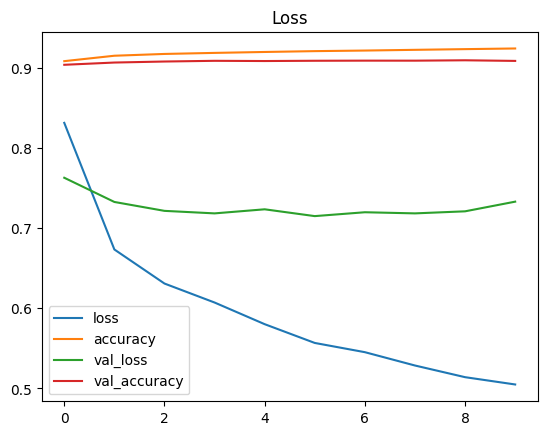

In [16]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.title("Loss")
plt.show()

In [17]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def bleu_score(input_data, output_data, input_tokenizer, output_tokenizer, model):
    bleu_scores = []
    smoothing_function = SmoothingFunction().method1  # Apply smoothing

    for i in range(len(input_data)):
        # Tokenize and pad single sentence
        input_seq = input_tokenizer.texts_to_sequences([input_data[i]])
        input_seq = pad_sequences(input_seq, maxlen=max_sequence_length, padding='post')
        
        # Predict for this single input
        prediction = model.predict(input_seq)
        
        # Decode the prediction to text
        predicted_seq = np.argmax(prediction[0], axis=-1)  # Use only the first (and only) batch element
        predicted_text = ' '.join([output_tokenizer.index_word.get(idx, '') for idx in predicted_seq if idx != 0])
        
        # Get the reference text
        reference_seq = output_tokenizer.texts_to_sequences([output_data[i]])
        reference_seq = pad_sequences(reference_seq, maxlen=max_sequence_length, padding='post')
        reference_text = ' '.join([output_tokenizer.index_word.get(idx, '') for idx in reference_seq[0] if idx != 0])
        
        # Tokenize the reference and predicted sentences
        reference_tokens = [reference_text.split()]
        predicted_tokens = predicted_text.split()
        
        # Calculate BLEU score for this sentence
        bleu_score_value = sentence_bleu(reference_tokens, predicted_tokens, smoothing_function=smoothing_function)
        bleu_scores.append(bleu_score_value)
        
        # Print predicted and reference text, and BLEU score for the current sentence
        print(f"Sentence {i + 1} Input Text: {input_data[i]}")
        print(f"Sentence {i + 1} Predicted Text: {predicted_text}")
        print(f"Sentence {i + 1} Reference Text: {reference_text}")
        print(f"Sentence {i + 1} BLEU Score: {bleu_score_value:.4f}")
        print("-" * 50)  # Separator for readability
    
    # Calculate the average BLEU score
    avg_bleu_score = np.mean(bleu_scores)
    print(f"Average BLEU Score: {avg_bleu_score:.4f}")


In [18]:
df_test = pd.read_parquet("hf://datasets/Helsinki-NLP/opus-100/en-id/test-00000-of-00001.parquet")

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   translation  2000 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB


In [19]:
num_of_data = 20

df_test_reduced = df_test.head(num_of_data)
df_test_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   translation  20 non-null     object
dtypes: object(1)
memory usage: 288.0+ bytes


In [20]:
english_test = df_test_reduced['translation'].apply(lambda x: x['en']).tolist()
indonesian_test = df_test_reduced['translation'].apply(lambda x: x['id']).tolist()

print(english_test[:5])
print(indonesian_test[:5])

['He was on the run.', "How d'ya like that, Spidey?", '- Staff Sergeant, sir!', "I'll be with her.", 'Because of us, they will be ruined.']
['Dia sedang dalam pelarian.', 'Bagaimana sekarang, Spidey?', '- Staf Sersan, Pak!', 'Aku akan bersamanya.', 'Karena kita, mereka akan hancur.']


In [21]:
bleu_score(english_test, indonesian_test, english_tokenizer, indonesian_tokenizer, model)

1/1 [==============================] - 0s 354ms/step
Sentence 1 Input Text: He was on the run.
Sentence 1 Predicted Text: dia adalah di
Sentence 1 Reference Text: dia sedang dalam pelarian
Sentence 1 BLEU Score: 0.0814
--------------------------------------------------
1/1 [==============================] - 0s 33ms/step
Sentence 2 Input Text: How d'ya like that, Spidey?
Sentence 2 Predicted Text: bagaimana dia suka
Sentence 2 Reference Text: bagaimana sekarang
Sentence 2 BLEU Score: 0.1136
--------------------------------------------------
1/1 [==============================] - 0s 38ms/step
Sentence 3 Input Text: - Staff Sergeant, sir!
Sentence 3 Predicted Text: lanjutkan bermain tuan
Sentence 3 Reference Text: staf sersan pak
Sentence 3 BLEU Score: 0.0000
--------------------------------------------------
1/1 [==============================] - 0s 52ms/step
Sentence 4 Input Text: I'll be with her.
Sentence 4 Predicted Text: aku akan dengan
Sentence 4 Reference Text: aku akan bersamanya

In [22]:
# Test the model with a sample input
def translate_sentence(input_tokenizer, output_tokenizer, sentence, model):
    seq = input_tokenizer.texts_to_sequences([sentence])
    seq = pad_sequences(seq, maxlen=max_sequence_length, padding='post')
    pred_seq = model.predict(seq)
    pred_seq = np.argmax(pred_seq, axis=-1)
    translated_words = [output_tokenizer.index_word.get(idx, '') for idx in pred_seq[0] if idx > 0]
    return ' '.join(translated_words)

In [23]:
sentence = "can we play now?"

print(translate_sentence(english_tokenizer, indonesian_tokenizer, sentence, model))

1/1 [==============================] - 0s 40ms/step
bisa kita bermain sekarang
